# U-Net
<u>Project Title</u>: Supervised Robot Tool Image Segmentation and Generation Methods \
<u>Group: 16</u> \
<u>Authors:</u> Aryaman Shodhan ashodha1,
Trisha Karani tkarani1,
Shreya Wadhwa swadhwa5,
Aidan Aug aaug1

---

**Notebook description**: This Colab Notebook implements a simplified version of U-Net, which includes pooling, Conv2DTranspose, Batch Norm, and Leaky ReLU layers.


# Setup: 

Mounting Drive, importing libraries, and determining device

In [ ]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
from datetime import datetime
from pytz import timezone
tz = timezone('US/Eastern')

In [ ]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

In [ ]:
import random
random.seed(3407)
torch.manual_seed(3407)
np.random.seed(3407)

# Data Preprocessing

NOTE: MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE CholecSeg8k DATA!!!

The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Shuffles the data
3. Splits data into an 60:10:10 train-val-test split
4. Generates an ImageDataset class based on this data for feeding into a dataloader
5. Resizes images into 192 x 320 pixel images
6. Visualizes data

In [ ]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
# data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan

mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [ ]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [ ]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None), #Ratios must be compatible with UNet
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask), num_workers=2)
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask), num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask), num_workers=2)

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 20
Batches of Validation Dataloader: 4
Batches of Testing Dataloader: 100


### Visualize Data

In [ ]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

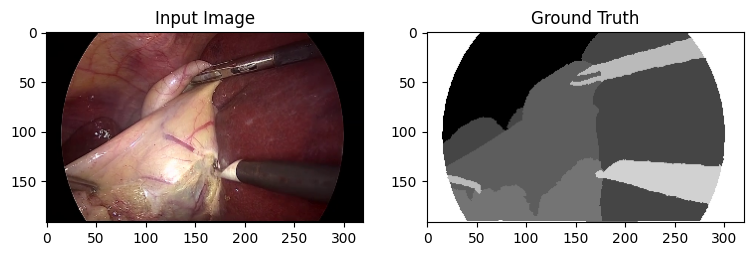

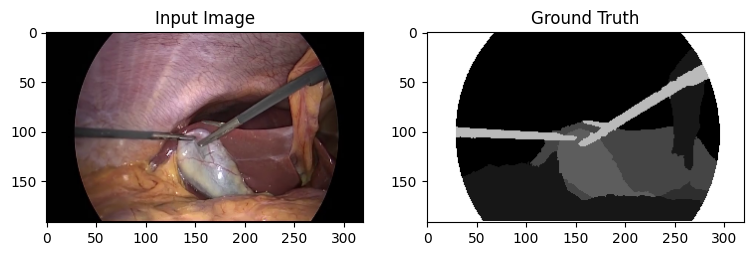

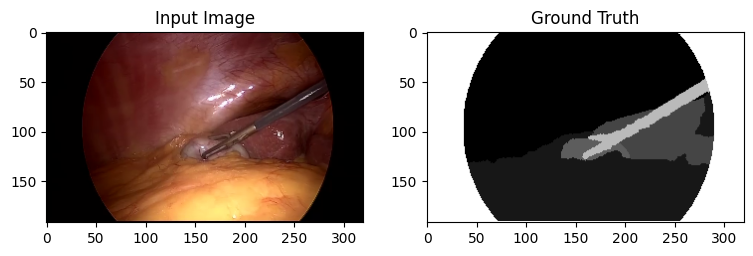

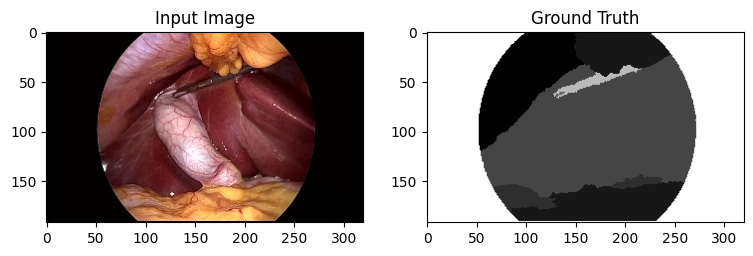

In [ ]:
visualize(train_dataloader, n_samples=4)

# Loss Functions

TODO: INCLUDE DESCRIPTION OF RATIONALE BEHIND DICELOSS AND IOU

Dice Loss

Remember to include references about where we got the equation from!

https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf

In [ ]:
# IOU Loss = 1 - (|A intersect B| / |A union B|)
class IOULoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(IOULoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks, n_classes):
    batch_size = target_masks.shape[0]
    iou_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      iou_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        iou_classes[cl] = intersection / (predicted_mask[cl].sum() + target_mask[cl].sum() - intersection)
      iou_scores[batch] = iou_classes.mean()
    return 1.0 - iou_scores.mean()

In [ ]:
# DICE Loss = 1 - (2 * |A intersect B| / (|A| + |B|))
class DICELoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(DICELoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks):
    n_classes = predicted_masks.shape[1]
    batch_size = target_masks.shape[0]
    dice_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      dice_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        dice_classes[cl] = 2 * intersection / (predicted_mask[cl].sum() + target_mask[cl].sum())
      dice_scores[batch] = dice_classes.mean()
    return 1.0 - dice_scores.mean()

In [ ]:
## Loss Functions Testing

# Batch has 1 item with 3 classes
predicted = torch.Tensor([
    # Class 1
    [[[0.2, 0.1, 0.05],
    [0.1, 0.3, 0.4],
    [0.6, 0.75, 0.25]],

    # Class 2
    [[0.25, 0.1, 0.9],
    [0.45, 0.2, 0.3],
    [0.2, 0.15, 0.05]],

    # Class 3
    [[0.55, 0.8, 0.05],
    [0.45, 0.5, 0.3],
    [0.2, 0.1, 0.7]]]
])

# Batch has 1 item with 3 classes
target = torch.Tensor([
    # Class 1
    [[[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0]],

    # Class 2
    [[1, 0, 1],
    [0, 1, 0],
    [0, 1, 0]],

    # Class 3
    [[0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]]
])

# IOU Score for Class 1: 1.0 / (2.0 + 2.75 - 1.0) = 0.2667
# IOU Score for Class 2: 1.5 / (4.0 + 2.6 - 1.5) = 0.2941
# IOU Score for Class 3: 1.95 / (3.0 + 3.65 - 1.95) = 0.4149
# Mean IOU Score: 0.3252
# Loss = 1 - 0.3252 = 0.6748
iou = IOULoss()
iou_loss = iou.forward(predicted, target, n_classes=3).item()
assert(iou_loss == 0.6747740507125854)

# DICE Score for Class 1: 2 * 1.0 / (2.0 + 2.75) = 0.4211
# DICE Score for Class 2: 2 * 1.5 / (4.0 + 2.6) = 0.4545
# DICE Score for Class 3: 2 * 1.95 / (3.0 + 3.65) = 0.5865
# Mean DICE Score: 0.4874
# Loss = 1 - 0.4874 = 0.5126
dice = DICELoss()
# dice_loss = dice.forward(predicted, target, n_classes=3).item()
dice_loss = dice.forward(predicted, target).item()

assert(dice_loss == 0.5126452445983887)

In [ ]:
def dice_score_image(prediction, target, n_classes):
    dice_classes = np.zeros(n_classes)

    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, use_gpu=False, is_deeplab_or_fcn=False):
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)

    model.eval()
    idx = 0
    for data in dataloader:

        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()

        out = model(img)
        if is_deeplab_or_fcn:
          out = out['out']
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = nn.functional.one_hot(prediction, n_classes)
        prediction = prediction.permute(0, 3, 1, 2)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1

    m_dice = scores.mean()
    return m_dice

# Training and Validation

In [ ]:
def test_eval(test_dataloader, model, loss, verbose = 1, is_deeplab_or_fcn=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          if i <= 5:
            fig, ax = plt.subplots(1, 3)
            img = outputs[0]
            img = np.argmax(img.cpu().numpy(), axis=0)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title("Predicted")    

            ax[1].imshow(np.argmax(labels[0].cpu().numpy(), axis=0), cmap="gray")
            ax[1].set_title("Labels")

            input = images[0].permute(1, 2, 0).cpu().numpy()
            ax[2].imshow(input)
            ax[2].set_title("Input")

            plt.show()
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def val_eval(val_dataloader, model, loss, verbose = 0, is_deeplab_or_fcn=False):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Val loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def train(model, train_data_loader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False):

  loss_fail = 0
  patience = 5
  best_model = model
  best_val_loss = float('inf')
  n_classes = 13
  print("Start Training...")
  print("{:<10} {:<20} {:<20} {:<20} {:<15} {:<15}".format('epoch', 'train loss','val loss', 'es_counter(/5)', 'min_val_loss', 'time(s)'))
  time_start = time.time() #timekeeping
  for epoch in range(num_epochs):
      ########################### Training #####################################
      time_epoch_start = time.time() #timekeeping
      loss_sum = 0
      correct = 0
      total = 0
      for i, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        if is_deeplab_or_fcn:
          outputs = outputs['out'] #only for DeepLabV3

        loss_val = loss(outputs, y)
        loss_val.backward()
        optimizer.step()

        # train eval
        loss_sum += loss_val.item()
        total += y.size(0)

      train_loss = loss_sum / total

      ########################### Validation #####################################
      val_loss = val_eval(validation_dataloader, model, loss, is_deeplab_or_fcn)

      # Early Stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        loss_fail = 0
      else:
        loss_fail += 1
      
      if loss_fail == patience:
          print("Stopping Early..")
          print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n", "Train Loss:",train_loss, "Validation Loss:",val_loss)
          break

      # Timekeeping
      time_epoch_end = time.time()
      total_time = time_epoch_end - time_start

      # Print statements + data keeping for graph
      if epoch % 2 == 0:
          print("{:<10} {:<20f} {:<20f} {:<20d} {:<15f} {:<15f}".format(
            epoch, train_loss, val_loss, loss_fail, round(best_val_loss,10), total_time))
      if epoch == 0:
          L = train_loss
          A = val_loss
      else:
          L = np.append(L,train_loss)
          A = np.append(A,val_loss)

  ## Plot Training Loss and Validation Loss
  plt.plot(L,'-', label='Training Loss')
  plt.plot(A,'-', label='Validation Loss')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='best')
  plt.show()

  return best_model

# EXPERIMENT 1 Comparing different segmentation models

This notebook explores the performance of a U-Net model for image segmentation, using BatchNorm2d, LeakyReLU, and MaxPool2D layers.

## UNET

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Define Model

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()


    def forward(self, x):
        """
        Forward pass
        """
        # Encoding
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        # Decoding
        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.078153             0.090639             0                    0.090639        652.531130     
2          0.071300             0.084055             0                    0.084055        788.529189     
4          0.067311             0.079910             0                    0.079910        923.661442     
6          0.064423             0.076553             0                    0.076553        1059.132637    
8          0.062498             0.074740             0                    0.074740        1196.798512    
10         0.060988             0.073040             0                    0.073040        1331.737348    
12         0.060172             0.072069             0                    0.072069        1468.721693    
14         0.059555             0.071496             0                    0.071496        1606.855261    
16         0.058953         

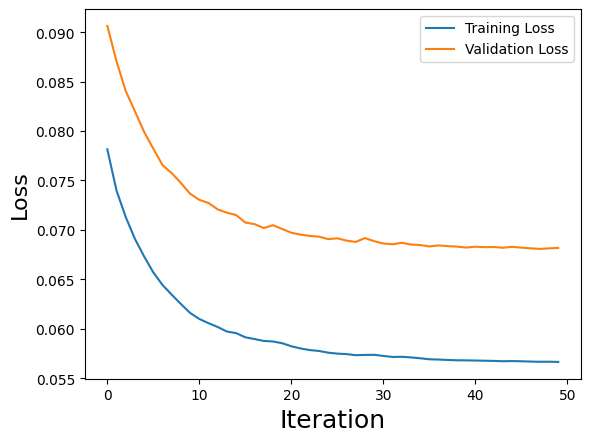

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = UNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

In [ ]:
dice_score_dataset(unet_trained, test_dataloader, n_classes, is_deeplab_or_fcn=False)

0.933272772957568

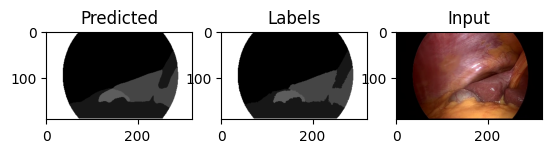

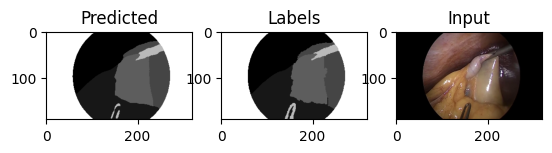

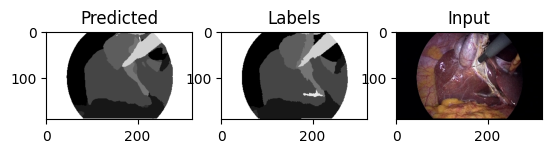

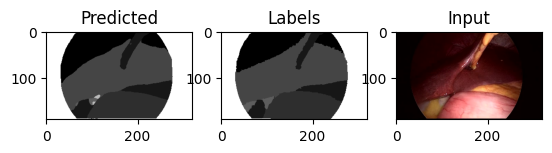

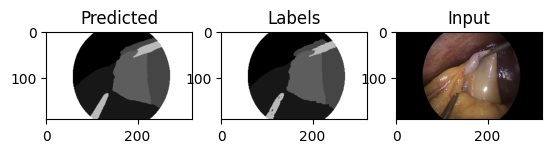

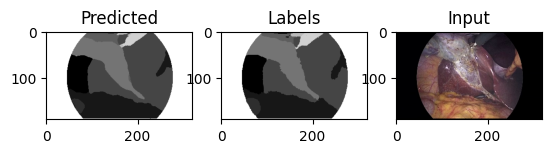

Test loss: 1.701004


1.7010040943212905

In [ ]:
test_eval(test_dataloader, unet_trained, loss, is_deeplab_or_fcn=False)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_trained, data_dir + f"saved_models/models/unet_trained_{cur_time}.pt")

# EXPERIMENT 2 TRANSFER LEARNING USING A SPECIFIC MODEL

This model is defined by the group, and therefore does not have a pretrained model to use.

# EXPERIMENT 3: RECOLORIZATION

Model pretrained on the unsupervized recolorization task can be found at 'path_to_main_directory/saved_models/models/unet_image_recolorization.pt' 


## UNet

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Redefine UNet to match Recolorization Module

In [ ]:
## Redefine UNET as in recolorization module
class UNET(nn.Module):

  def __init__(self, n_classes, useBN=True):
    super(UNET, self).__init__()
    # Downgrade Stages
    self.conv1 = add_conv_stage(dim_in=3, dim_out=32, useBN=useBN)
    self.conv2 = add_conv_stage(dim_in=32, dim_out=64, useBN=useBN)
    self.conv3 = add_conv_stage(dim_in=64, dim_out=128, useBN=useBN)
    self.conv4 = add_conv_stage(dim_in=128, dim_out=256, useBN=useBN)

    # Upgrade Stages
    self.conv3m = add_conv_stage(dim_in=256, dim_out=128, useBN=useBN)
    self.conv2m = add_conv_stage(dim_in=128, dim_out=64, useBN=useBN)
    self.conv1m = add_conv_stage(dim_in=64, dim_out=32, useBN=useBN)

    # Maxpool
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # Upsample Layers
    self.upsample43 = upsample(ch_coarse=256, ch_fine=128)
    self.upsample32 = upsample(ch_coarse=128, ch_fine=64)
    self.upsample21 = upsample(ch_coarse=64, ch_fine=32)

    # Final Layer
    self.conv1x1 = add_conv_stage(dim_in=32, dim_out=n_classes, kernel_size=1, padding=0, useBN=useBN)

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), dim=1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), dim=1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), dim=1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv_out = self.conv1x1(conv1m_out)

    return conv_out

### Training (freezing layers)

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.080229             0.095049             0                    0.095049        91.891711      
2          0.077466             0.092741             0                    0.092741        284.808977     
4          0.076117             0.090889             0                    0.090889        477.055716     
6          0.074720             0.089909             0                    0.089909        679.813663     
8          0.073960             0.088868             0                    0.088868        880.963961     
10         0.073269             0.087893             0                    0.087893        1075.650727    
12         0.072642             0.087040             0                    0.087040        1268.765075    
14         0.072078             0.086664             0                    0.086664        1463.430036    
16         0.071573         

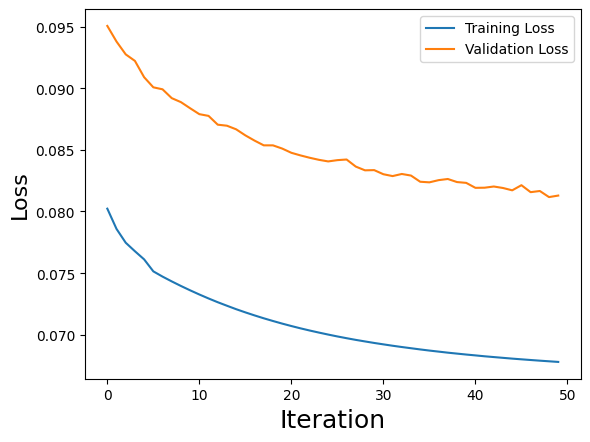

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13

pre_recolor_unet_model = torch.load(data_dir + 'saved_models/models/unet_image_recolorization.pt')

# freezing all but last layers
for param in pre_recolor_unet_model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
pre_recolor_unet_model.conv1x1 = nn.Sequential(
    nn.Conv2d(32, n_classes, kernel_size=(1, 1), stride=(1, 1)),
)

pre_recolor_unet_model = pre_recolor_unet_model.to(device)

optimizer = torch.optim.Adam(pre_recolor_unet_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_recolored_segmentation = train(pre_recolor_unet_model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

In [ ]:
dice_score_dataset(unet_recolored_segmentation, test_dataloader, n_classes, is_deeplab_or_fcn=False)

0.618204465913144

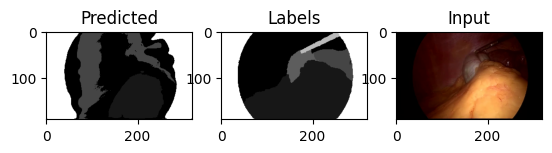

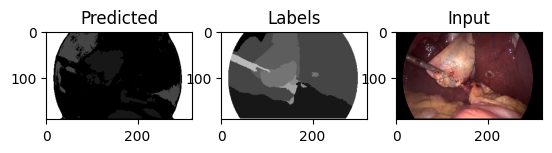

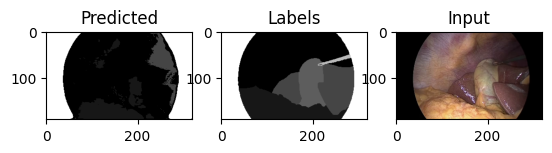

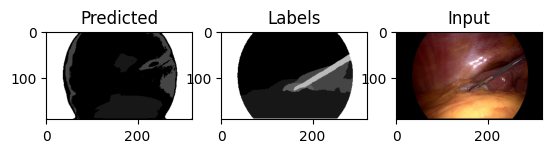

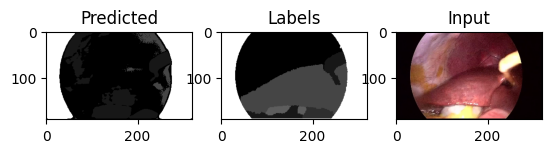

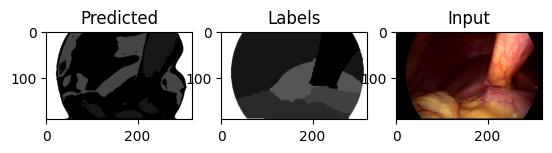

Test loss: 2.023051


2.023050747292382

In [ ]:
test_eval(test_dataloader, unet_recolored_segmentation, loss, is_deeplab_or_fcn=False)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_recolored_segmentation, data_dir + f"saved_models/models/unet_recolored_segmentation_{cur_time}.pt")

### Training (not freezing layers)

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.062466             0.056253             0                    0.056253        331.622603     
2          0.035171             0.039207             0                    0.039207        536.101320     
4          0.030516             0.035015             0                    0.035015        744.275570     
6          0.027075             0.031828             0                    0.031828        948.765068     
8          0.024491             0.027181             0                    0.027181        1149.036152    
10         0.020787             0.024312             0                    0.024312        1344.166422    
12         0.018265             0.020965             0                    0.020965        1537.628219    
14         0.016474             0.019804             1                    0.019684        1729.207079    
16         0.014752         

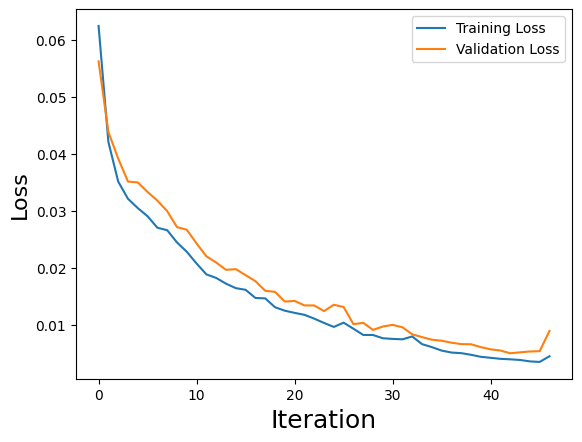

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13

pre_recolor_unet_model = torch.load(data_dir + 'saved_models/models/unet_image_recolorization.pt')

# Modify the final layer to output the correct number of classes
pre_recolor_unet_model.conv1x1 = nn.Sequential(
    nn.Conv2d(32, n_classes, kernel_size=(1, 1), stride=(1, 1)),
)

pre_recolor_unet_model = pre_recolor_unet_model.to(device)

optimizer = torch.optim.Adam(pre_recolor_unet_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_recolored_segmentation = train(pre_recolor_unet_model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

In [ ]:
dice_score_dataset(unet_recolored_segmentation, test_dataloader, n_classes, is_deeplab_or_fcn=False)

0.797778387898252

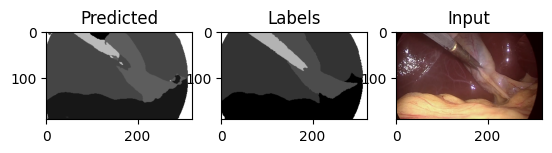

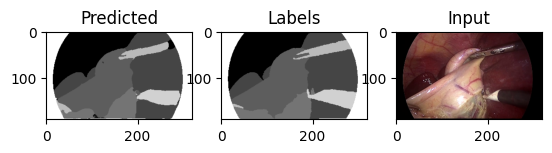

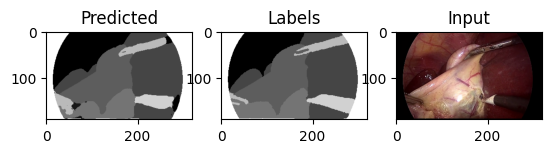

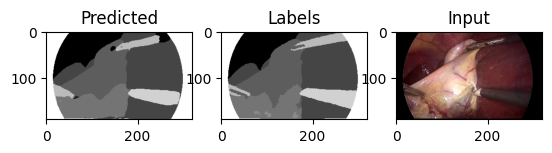

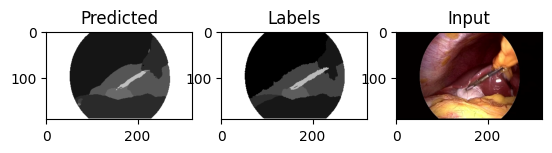

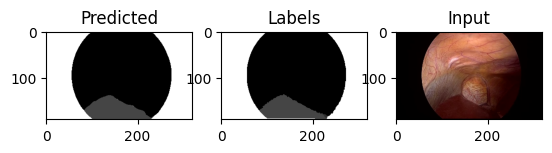

Test loss: 0.173628


0.1736282790450494

In [ ]:
test_eval(test_dataloader, unet_recolored_segmentation, loss, is_deeplab_or_fcn=False)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_recolored_segmentation, data_dir + f"saved_models/models/unet_recolored_no_freeze_{cur_time}.pt")

### RECOLORIZATION trained on GAN - 50% Fake Images

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.078981             0.085186             0                    0.085186        589.129241     
2          0.069364             0.083305             0                    0.083305        720.681560     
4          0.068905             0.083765             2                    0.083305        854.676368     
6          0.068600             0.083223             0                    0.083223        987.813325     
8          0.068486             0.082681             0                    0.082681        1122.004814    
10         0.064869             0.077641             0                    0.077641        1255.913547    
12         0.063537             0.075827             0                    0.075827        1387.152554    
14         0.062856             0.075203             0                    0.075203        1518.199760    
16         0.062526         

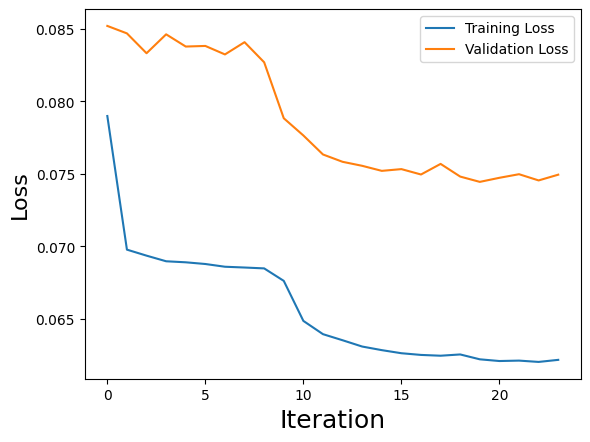

In [ ]:
## Run Training Loop
torch.cuda.empty_cache()
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13

pre_recolor_unet_GAN_50_model = torch.load(data_dir + 'saved_models/models/unet_GAN_image_recolorization.pt')

# Modify the final layer to output the correct number of classes
pre_recolor_unet_GAN_50_model.final_layer = nn.Conv2d(32, n_classes, kernel_size=(1, 1), stride=(1, 1))
pre_recolor_unet_GAN_50_model.final_activation = nn.Softmax(dim=1)

pre_recolor_unet_GAN_50_model = pre_recolor_unet_GAN_50_model.to(device)

optimizer = torch.optim.Adam(pre_recolor_unet_GAN_50_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_recolored_GAN_50= train(pre_recolor_unet_GAN_50_model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

0.7399901742802725


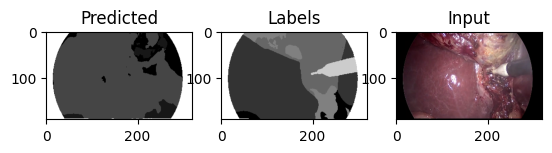

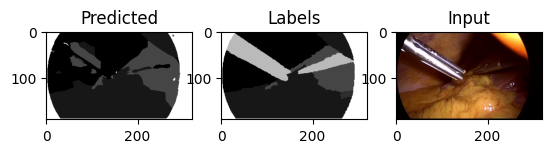

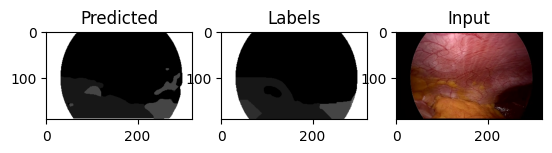

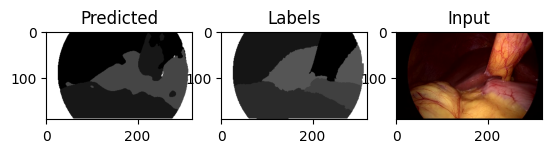

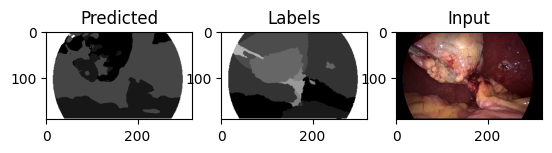

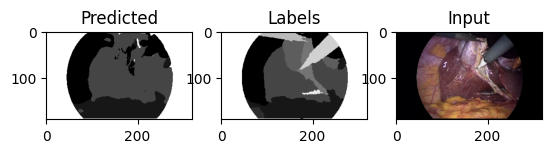

Test loss: 1.840435


1.8404345322428848

In [ ]:
print(dice_score_dataset(unet_recolored_GAN_50, test_dataloader, n_classes, is_deeplab_or_fcn=False))
test_eval(test_dataloader, unet_recolored_GAN_50, loss, is_deeplab_or_fcn=False)

In [ ]:
# Save Model
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_recolored_GAN_50, data_dir + f"saved_models/models/unet_recolored_GAN_50_no_freeze_{cur_time}.pt")

### RECOLORIZATION trained on GAN - 100% Fake Images

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.076777             0.085011             0                    0.085011        1307.532658    
2          0.067835             0.079780             0                    0.079780        1497.955894    
4          0.065296             0.077652             0                    0.077652        1690.810760    
6          0.063900             0.076359             0                    0.076359        1883.463594    
8          0.063420             0.076221             0                    0.076221        2071.615529    
10         0.062892             0.076265             1                    0.076178        2267.997849    
12         0.062658             0.075265             0                    0.075265        2461.737967    
14         0.062356             0.075200             1                    0.075049        2656.901546    
16         0.062269         

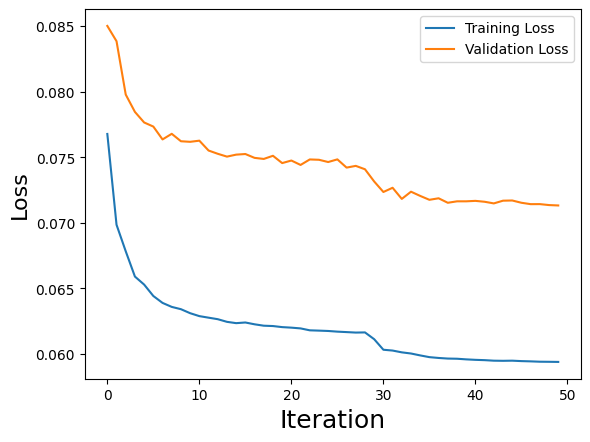

In [ ]:
## Run Training Loop
torch.cuda.empty_cache()
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13

pre_recolor_unet_GAN_100_model = torch.load(data_dir + 'saved_models/models/unet_GAN_recolorization.pt')

# Modify the final layer to output the correct number of classes
pre_recolor_unet_GAN_100_model.final_layer = nn.Conv2d(32, n_classes, kernel_size=(1, 1), stride=(1, 1))
pre_recolor_unet_GAN_100_model.final_activation = nn.Softmax(dim=1)

pre_recolor_unet_GAN_100_model = pre_recolor_unet_GAN_100_model.to(device)

optimizer = torch.optim.Adam(pre_recolor_unet_GAN_100_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_recolored_GAN_100= train(pre_recolor_unet_GAN_100_model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

0.792625001331478


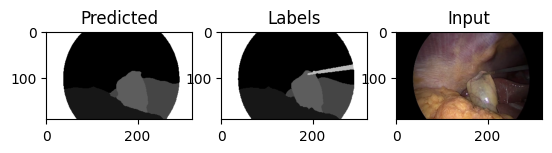

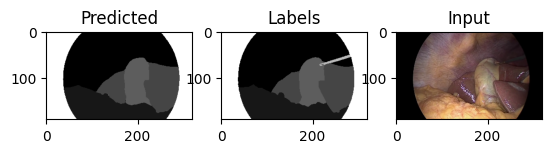

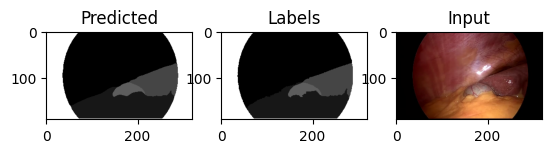

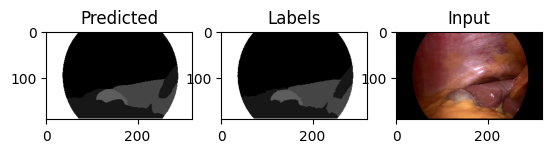

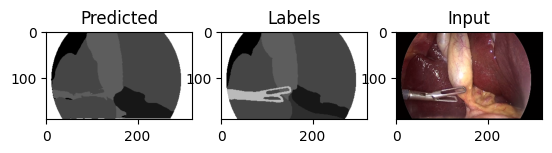

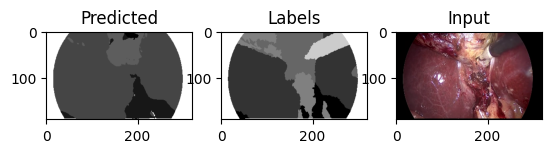

Test loss: 1.778845


1.7788454163374414

In [ ]:
print(dice_score_dataset(unet_recolored_GAN_100, test_dataloader, n_classes, is_deeplab_or_fcn=False))
test_eval(test_dataloader, unet_recolored_GAN_100, loss, is_deeplab_or_fcn=False)

In [ ]:
# Save Model
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_recolored_GAN_100, data_dir + f"saved_models/models/unet_recolored_GAN_100_no_freeze_{cur_time}.pt")

# EXPERIMENT 4: DATA AUGMENTATION

Here, we apply RandomHorizontalFlip() and RandomVerticalFlip() to generate valid data augmentations

## Apply Data Augmentation

In [ ]:
# Redefine ImageDataset
class ImageDatasetDataAug(Dataset):
  def __init__(self, data, mask_json, req_transforms=None, data_aug=[]):
    self.data = data
    self.mask_json = mask_json
    self.transforms = req_transforms
    self.data_aug = data_aug


    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    for i in range(len(self.data_aug)):
      if random.random() > 0.5:
        data_aug = self.data_aug[i]
        img = data_aug(img)
        mask = data_aug(mask)


    return img, mask

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

data_aug = [transforms.functional.vflip, transforms.functional.hflip]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


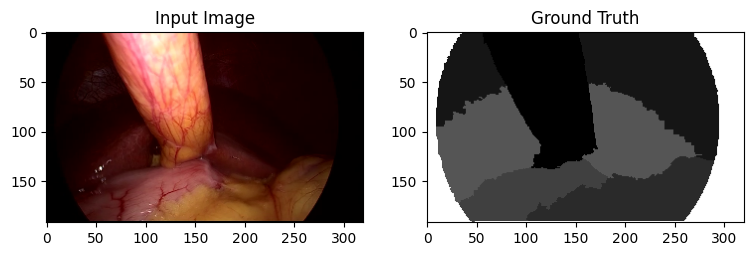

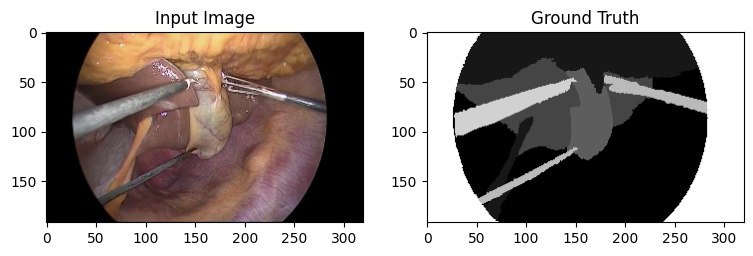

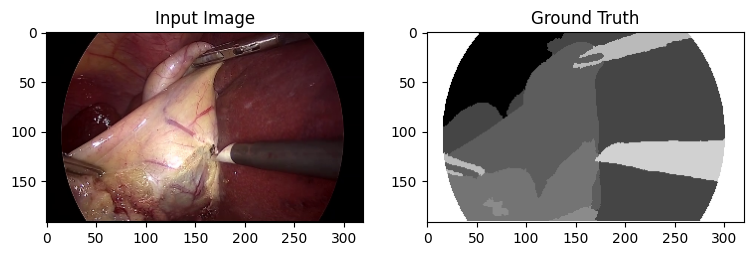

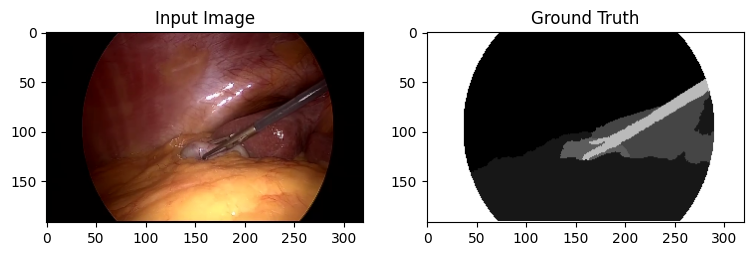

In [ ]:
visualize(train_dataloader, n_samples=4)

## UNet

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Redefine Model

In [ ]:
# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations

        # Last layer of UNet is 1x1 convolution with 1 filter of size 1x1
        self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)

        # Will use softmax since n_classes is provided as a parameters, 
        # but this is a two class classification problem (i.e., only need sigmoid)
        self.final_activation = nn.Sigmoid()


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        softmax_probs = self.final_layer(conv1m_out)
        output = self.final_activation(softmax_probs)
        
        return output


### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.077459             0.089646             0                    0.089646        936.576447     
2          0.070771             0.084059             0                    0.084059        1132.791680    
4          0.067255             0.080003             0                    0.080003        1331.737217    
6          0.064897             0.077463             0                    0.077463        1532.259237    
8          0.063310             0.075816             0                    0.075816        1730.029857    
10         0.062350             0.074317             0                    0.074317        1928.058996    
12         0.061725             0.074154             0                    0.074154        2128.627788    
14         0.061008             0.073152             0                    0.073152        2330.165238    
16         0.060514         

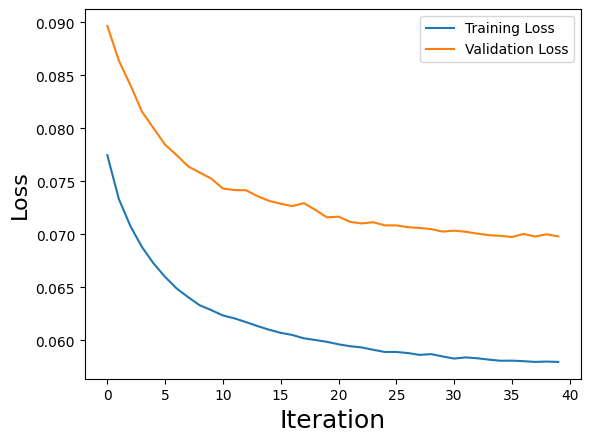

In [ ]:
## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 #Change to 200 later

## Setting up the model, optimizer, and loss function
n_classes = 13
model = UNET(n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
unet_data_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False)

In [ ]:
dice_score_dataset(unet_data_aug, test_dataloader, n_classes, is_deeplab_or_fcn=False)

0.8547260749852239

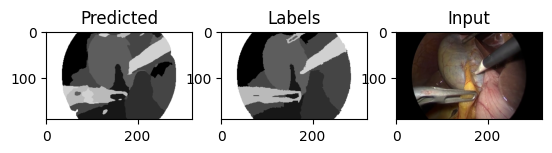

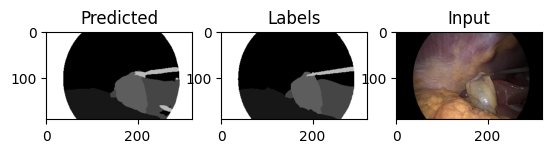

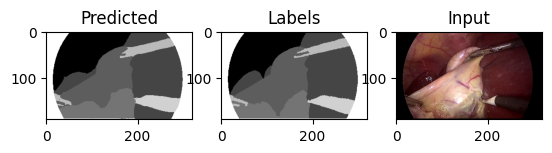

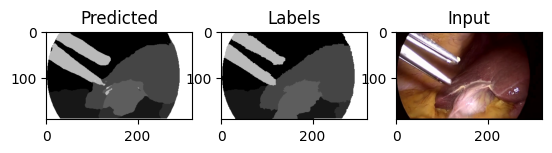

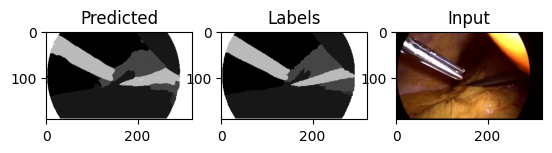

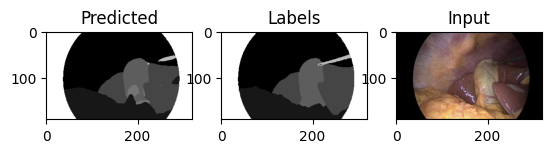

Test loss: 1.731942


1.7319421295075748

In [ ]:
test_eval(test_dataloader, unet_data_aug, loss, is_deeplab_or_fcn=False)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(unet_data_aug, data_dir + f"saved_models/models/unet_data_aug_{cur_time}.pt")